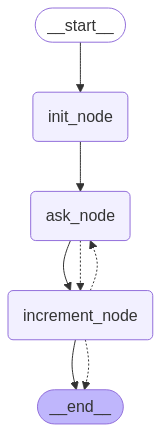

Final state: {'current_question_index': 3, 'questions': [{'text': 'At what age were you diagnosed with polymicrogyria, and what were the primary signs or symptoms?', 'requirements': {'age': 'Provide age (based on birthdate)', 'diagnosis_date': 'Provide the date of diagnosis', 'symptoms': 'Describe the key signs and symptoms'}}, {'text': 'What symptoms or neurological issues do you experience, and how would you rate their severity?', 'requirements': {'symptoms': 'List each symptom or neurological issue experienced', 'severity': 'Include a severity rating for each (mild, moderate, severe)', 'context': 'Provide any additional context about how symptoms impact daily life'}}, {'text': 'Can you describe the key findings from your brain imaging studies (MRI/CT)?', 'requirements': {'imaging_modality': 'Specify the imaging modality used (MRI, CT, etc.)', 'findings': 'Detail the main imaging findings', 'remarks': 'Include any remarks from radiology reports'}}], 'conversation_history': [{'role': 

In [ ]:
# ----------------------------------------------------------------------------------
# Imports and Setup
# ----------------------------------------------------------------------------------
from langgraph.graph import StateGraph, START, END  # StateGraph builds the workflow; START/END mark the flow boundaries.
from langgraph.types import Command                # Command objects combine state updates with control flow decisions.
from langchain_openai import ChatOpenAI            # Demonstrates how you might integrate GPT-4 (here as "gpt-4o").
from typing import Literal, List, Dict             # Type annotations for clarity.
from dataclasses import dataclass, field           # For constructing the conversation state with defaults.
from dotenv import load_dotenv
import os

# Load environment variables, e.g., for the OpenAI API key.
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY is not set in your environment.")

# ----------------------------------------------------------------------------------
# Define the ChatState Schema
# ----------------------------------------------------------------------------------
@dataclass
class ChatState:
    """
    ChatState tracks the entire state of the conversation, including:
    - current_question_index: Which question the user is on.
    - questions: The list of question objects. Each contains a 'text' field and 'requirements'.
    - conversation_history: A chronological list of all AI and human messages.
    - responses: A dictionary mapping the question index to the user's answer.
    """
    current_question_index: int = 0
    questions: List[Dict[str, Dict[str, str]]] = field(default_factory=list)
    conversation_history: List[Dict[str, str]] = field(default_factory=list)
    responses: Dict[int, str] = field(default_factory=dict)

# ----------------------------------------------------------------------------------
# Instantiate the GPT-4 Model (using gpt-4o)
# ----------------------------------------------------------------------------------
model = ChatOpenAI(model_name="gpt-4o", openai_api_key=openai_api_key)
# Note: Although not used directly here, this can be extended
# to generate or refine questions or analyze answers in future expansions.

# ----------------------------------------------------------------------------------
# Node 1: init_node
# ----------------------------------------------------------------------------------
def init_node(state: ChatState) -> ChatState:
    """
    Initializes the state if 'questions' is empty.
    This node sets up the default list of questions, conversation history, and responses.
    """
    if not state.questions:
        state.questions = [
            {
                "text": "At what age were you diagnosed with polymicrogyria, and what were the primary signs or symptoms?",
                "requirements": {
                    "age": "Provide age (based on birthdate)",
                    "diagnosis_date": "Provide the date of diagnosis",
                    "symptoms": "Describe the key signs and symptoms"
                }
            },
            {
                "text": "What symptoms or neurological issues do you experience, and how would you rate their severity?",
                "requirements": {
                    "symptoms": "List each symptom or neurological issue experienced",
                    "severity": "Include a severity rating for each (mild, moderate, severe)",
                    "context": "Provide any additional context about how symptoms impact daily life"
                }
            },
            {
                "text": "Can you describe the key findings from your brain imaging studies (MRI/CT)?",
                "requirements": {
                    "imaging_modality": "Specify the imaging modality used (MRI, CT, etc.)",
                    "findings": "Detail the main imaging findings",
                    "remarks": "Include any remarks from radiology reports"
                }
            }
        ]
        state.current_question_index = 0
        state.conversation_history = []
        state.responses = {}
    return state

# ----------------------------------------------------------------------------------
# Interrupt Function (Interactive Testing)
# ----------------------------------------------------------------------------------
def interrupt(prompt_obj) -> str:
    """
    Interactive function: waits for user input in the notebook.
    If the input is empty, warns the user and prompts again.
    This is for a Jupyter/terminal-based flow where the user can type an answer.
    """
    while True:
        answer = input(prompt_obj["prompt"] + "\nYour answer: ")
        if answer.strip() == "":
            print("Empty input detected. Please provide a valid answer.")
        else:
            return answer

# ----------------------------------------------------------------------------------
# Node 2 (Interactive): ask_node
# ----------------------------------------------------------------------------------
def ask_node(state: ChatState) -> Command[Literal["increment_node"]]:
    """
    Interactive ask node that retrieves the current question,
    waits for user input (via interrupt), and stores the answer.
    This node is specifically for notebook/terminal usage.
    
    Steps:
    1. Retrieve current question from state.
    2. Append AI prompt to conversation_history.
    3. Call interrupt() to capture user input.
    4. Append user's answer to conversation_history & store in responses.
    5. Return a Command with updated state, routing to 'increment_node'.
    """
    idx = state.current_question_index
    question_obj = state.questions[idx]
    prompt = f"{question_obj['text']}\nRequirements: {question_obj['requirements']}"

    # Append the AI question to the conversation history.
    state.conversation_history.append({"role": "ai", "content": prompt})

    # Wait for user input (in the notebook).
    user_answer = interrupt({"prompt": prompt})

    # Record user's response in the conversation and in the responses dict.
    state.conversation_history.append({"role": "human", "content": user_answer})
    state.responses[idx] = user_answer

    return Command(goto="increment_node", update=state)

# ----------------------------------------------------------------------------------
# Node 3: increment_node
# ----------------------------------------------------------------------------------
def increment_node(state: ChatState) -> Command[Literal["ask_node", END]]:
    """
    Increments the current question index.
    If all questions are answered, routes to END.
    Otherwise, loops back to ask_node for the next question.
    
    This ensures the conversation continues until each question is answered.
    """
    state.current_question_index += 1
    if state.current_question_index >= len(state.questions):
        return Command(goto=END, update=state)
    return Command(goto="ask_node", update=state)

# ----------------------------------------------------------------------------------
# Build the Graph
# ----------------------------------------------------------------------------------
builder = StateGraph(ChatState)
builder.add_node("init_node", init_node)
builder.add_node("ask_node", ask_node)  # Using the interactive node for Jupyter
builder.add_node("increment_node", increment_node)

builder.add_edge(START, "init_node")
builder.add_edge("init_node", "ask_node")
builder.add_edge("ask_node", "increment_node")
builder.add_edge("increment_node", END)

graph = builder.compile()

# ----------------------------------------------------------------------------------
# Visualize the Graph with Mermaid
# ----------------------------------------------------------------------------------
from IPython.display import Image, display
mermaid_png = graph.get_graph().draw_mermaid_png()
display(Image(mermaid_png))

# ----------------------------------------------------------------------------------
# Test the Graph in a Jupyter Notebook
# ----------------------------------------------------------------------------------
initial_state = ChatState()  # Create an instance of ChatState with defaults.
final_state = graph.invoke(initial_state)
print("Final state:", final_state)
